In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

data = pd.read_csv("train.csv")

X = data.drop(columns=['target'])
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_t = torch.tensor(X_train.values, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_t = torch.tensor(X_test.values, dtype=torch.float32)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)


In [ ]:
#Архитектура модели
def build_model(input_dim):
    model = nn.Sequential(
        nn.Linear(input_dim, 32),  
        nn.ReLU(),
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Linear(16, 8),          
        nn.ReLU(),
        nn.Linear(8, 1),           
        nn.Sigmoid()              
    )
    return model

In [ ]:
import numpy as np

# Вспомогательные функции

def set_random_seed(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


#Функция обучения
def train_model(model, X_train, y_train, X_test, y_test, epochs=100, lr=0.005):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        preds = (model(X_test) > 0.5).float()
        acc = accuracy_score(y_test, preds)
    return acc


In [4]:
set_random_seed()

default_model = build_model(X_train_t.shape[1])

default_acc = train_model(default_model, X_train_t, y_train_t, X_test_t, y_test_t)

print(f"Точность = {default_acc*100:.2f}%")


Точность = 55.04%


### Сначала прогнал через модель данные без предобработки

In [5]:
scaler = MinMaxScaler()
num_features = ['area','perimeter','major_axis','minor_axis','eqdiasq','convex_area', 'aspect_ratio']
X[num_features] = scaler.fit_transform(X[num_features])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_t = torch.tensor(X_train.values, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_t = torch.tensor(X_test.values, dtype=torch.float32)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

#### Добавил нормализацию

In [7]:
set_random_seed()

norm_model = build_model(X_train_t.shape[1])

norm_acc = train_model(norm_model, X_train_t, y_train_t, X_test_t, y_test_t)

print(f"Точность = {norm_acc*100:.2f}%")

Точность = 84.88%


#### Результат сильно лучше

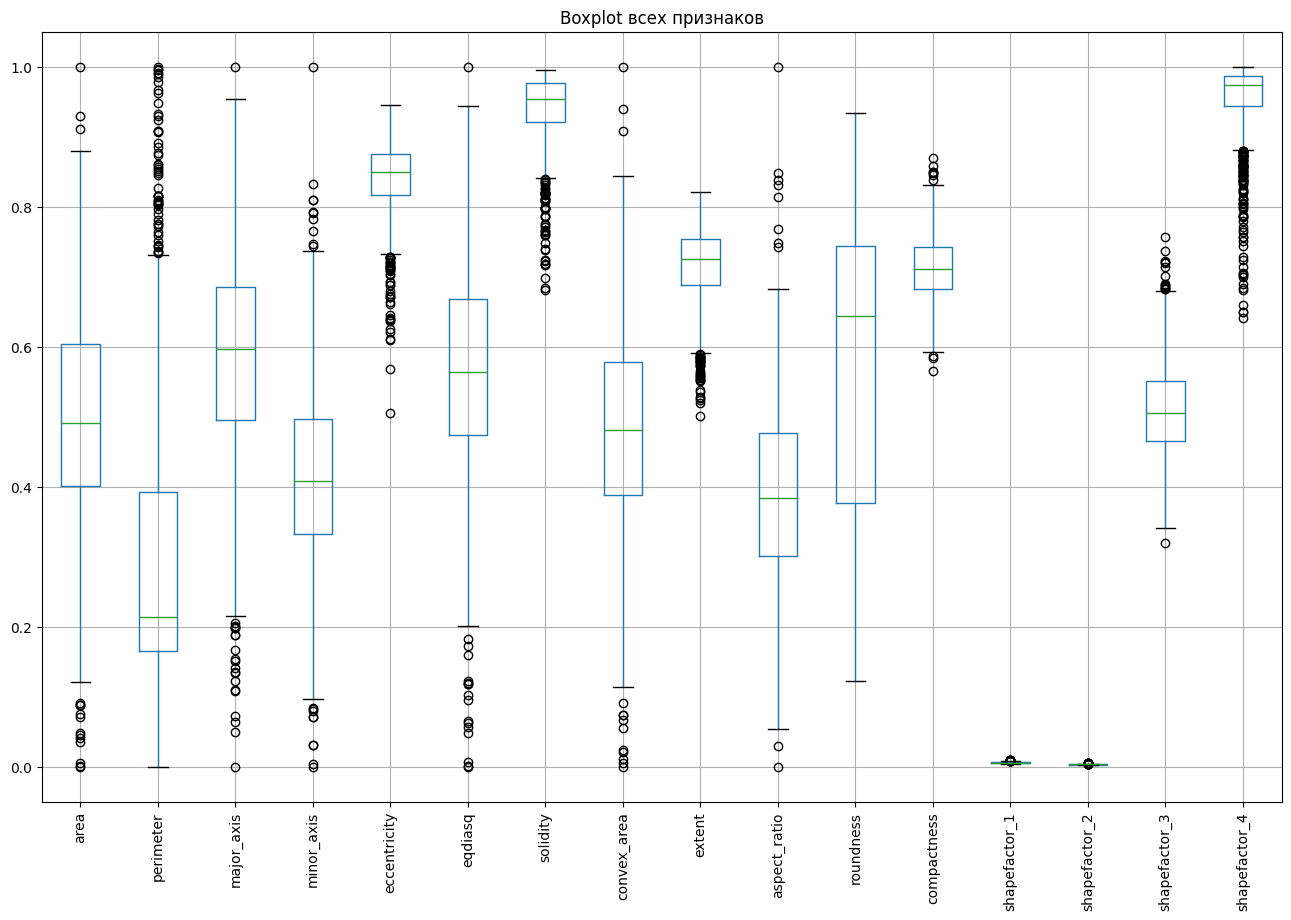

In [8]:
import matplotlib.pyplot as plt

features = ['area','perimeter','major_axis','minor_axis','eccentricity',
            'eqdiasq','solidity','convex_area','extent','aspect_ratio',
            'roundness','compactness','shapefactor_1','shapefactor_2',
            'shapefactor_3','shapefactor_4']

plt.figure(figsize=(16, 10))
X[features].boxplot(rot=90)
plt.title("Boxplot всех признаков")
plt.show()

In [9]:
import pandas as pd
import numpy as np
from scipy import stats

zscore_features = [
    'roundness', 'compactness',
    'shapefactor_1', 'shapefactor_2', 'shapefactor_3', 'shapefactor_4'
]

iqr_features = [
    'area', 'perimeter', 'major_axis', 'minor_axis', 'eqdiasq',
    'solidity', 'convex_area', 'extent', 'aspect_ratio'
]

data = X.copy()
data['target'] = y

for col in iqr_features:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    before = len(data)
    data = data[(data[col] >= lower) & (data[col] <= upper)]
    after = len(data)

for col in zscore_features:
    z_scores = np.abs(stats.zscore(data[col]))
    before = len(data)
    data = data[z_scores < 3]
    after = len(data)

X_cleaned = data.drop(columns=['target'])
y_cleaned = data['target']

print(f"\nИтоговый размер датасета: {X_cleaned.shape[0]} строк из {X.shape[0]}")



Итоговый размер датасета: 1091 строк из 1288


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X_cleaned, y_cleaned, test_size=0.2, random_state=42
)

set_random_seed(40)

X_train_t = torch.tensor(X_train.values, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_t = torch.tensor(X_test.values, dtype=torch.float32)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

cleaned_model = build_model(X_train_t.shape[1])

cleaned_acc = train_model(cleaned_model, X_train_t, y_train_t, X_test_t, y_test_t, 600)

print(f"Точность = {cleaned_acc*100:.2f}%")


Точность = 86.76%


#### Далее я производил всевозможные манипуляции над самой моделью(менял размер и количество слоев, dropout, кол-во эпох и т.д) и не получил результата лучше этого :(